# Batch Document OCR with Deepseek-OCR & HF jobs

This notebook runs a three-stage OCR pipeline on Hugging Face Jobs:

1. **Extract** – Run DeepSeek OCR over a dataset, save Markdown and crop detected figures
2. **Describe** – Generate captions for extracted figures  
3. **Assemble** – Enrich Markdown with figure captions in a final markdown.

![Extract Stage Pipeline](../assets/extract-hf.png)

All three stages write to **a single HF dataset repository**. Each stage pulls the current dataset, adds new columns with its outputs, and pushes the updated dataset back — so by the end you have one dataset with all intermediate and final results.


## 📑 Table of Contents

1. [Setup](#Setup)
   - [Hugging Face Jobs](#⚙️-Hugging-Face-Jobs)
   - [How the pipeline code is shipped](#How-the-pipeline-code-is-shipped-via-an-HF-*dataset-repo*-and-loaded-on-the-Job)
   - [The dataset](#📚-The-dataset)
   - [Inference Backend: vLLM](#⚡-Inference-Backend:-vLLM)
2. [Configuration](#Configuration)
3. [Upload Pipeline Code](#Upload-Pipeline-Code)
4. [Helper Functions](#Helper-Functions)
5. [Stage 1: Extract](#Stage-1:-Extract)
6. [Stage 2: Describe](#Stage-2:-Describe)
7. [Stage 3: Assemble](#Stage-3:-Assemble)
8. [Cost Analysis](#💰-Cost-Analysis)

## Setup


### 🤗 Hugging Face Jobs 
HF Jobs run a command in a Docker image on Hugging Face-managed compute (CPU/GPU/TPU). You pick an image, a command, and optionally a hardware flavor (e.g. a10g-small). Jobs are pay-as-you-go, require you to be logged in, and you can inspect status, read logs, and cancel later. See: [HF Jobs guide](https://huggingface.co/docs/huggingface_hub/en/guides/jobs)


### 📦 How the pipeline code is shipped via an HF *dataset repo* and loaded on the Job

**Local (this notebook)** bundles code → uploads it to `CODE_REPO` (a dataset repo):
- `hf_job_runner.py` (entrypoint)
- `llm_ocr/` (pipeline package)

**Runtime (inside the HF Job container)** pulls that code onto the instance:

```text
(1) Local (this notebook): upload code bundle to the Hub
    hf_job_runner.py
    llm_ocr/
        └── upload_folder ──▶ HF dataset repo: CODE_REPO (e.g. main)
                             /hf_job_runner.py
                             /llm_ocr/...

(2) Start a Job that points at the entrypoint script URL
    hf jobs / `run_uv_job(...)` runs (HF downloads + executes):
    `https://huggingface.co/datasets/<CODE_REPO>/resolve/main/hf_job_runner.py`
```
Inside the Job container, execution is:
- **Step 1 (entrypoint)**: run `hf_job_runner.py`
- **Step 2 (download project code)**: `snapshot_download(repo_id=JOB_CODE_REPO, repo_type="dataset", revision=...)`
  - writes the repo contents to `JOB_CODE_LOCAL_DIR` (default: `/tmp/deepseek-ocr-job-code`)
- **Step 3 (import + run)**: add that folder to `sys.path`, then:
  - `import llm_ocr.cli`
  - call `llm_ocr.cli.main()`



**Data flow is separate (another dataset repo):** stages read/write `DATASET_REPO`.
- **Download**: `datasets.load_dataset(HF_REPO_ID, token=HF_TOKEN)` pulls the dataset onto the instance (via the `datasets` cache)
- **Upload**: `dataset.push_to_hub(HF_REPO_ID, token=HF_TOKEN, commit_message=...)` pushes updated rows back to the Hub

(Reference: [HF Jobs guide](https://huggingface.co/docs/huggingface_hub/en/guides/jobs))


###  📚 The dataset 

This pipeline uses **FineVision** (`HuggingFaceM4/FineVision`) as a large, mixed **image+text** corpus for vision-language training/evaluation. FineVision aggregates many public sub-datasets into one unified interface, and you select a specific *subset/config* when loading.

- **Dataset**: [`HuggingFaceM4/FineVision`](https://huggingface.co/datasets/HuggingFaceM4/FineVision)
- **Overview / exploration space**: [`HuggingFaceM4/FineVision` Space](https://huggingface.co/spaces/HuggingFaceM4/FineVision)

#### The `olmOCR` subsets

The [`olmOCR-mix-0225`](https://arxiv.org/pdf/2502.18443) dataset from Allen AI contains **260,000 crawled PDF pages** from over 100,000 diverse PDFs — academic papers, legal documents, public domain books, brochures, and more. It includes challenging content: graphics, handwritten text, multi-column layouts, tables, equations, and poor quality scans.

Available configs:
- `olmOCR-mix-0225-documents` — general documents
- `olmOCR-mix-0225-books` — book pages

These mirror real-world enterprise use cases: contracts, invoices, reports, forms, and scanned documents that organizations need to digitize and extract structured information from.

> **Licensing note**: FineVision is a *collection* of many datasets, each with its own license/terms. Make sure the subset you use is compatible with your intended downstream use (see the dataset card for details).

### ⚡ Inference Backend: vLLM

This pipeline uses [**vLLM**](https://github.com/vllm-project/vllm) as the inference backend for DeepSeek-OCR. vLLM provides:

- **High throughput** via continuous batching and PagedAttention
- **OpenAI-compatible API** — easy to integrate with existing code
- **Efficient memory management** — run large models on limited GPU memory

The HF Job runs the [`vllm/vllm-openai:v0.12.0`](https://hub.docker.com/r/vllm/vllm-openai) Docker image, which starts a vLLM server. The pipeline sends batched requests (64 concurrent) to saturate the GPU and maximize throughput (~85 docs/min on A100).

Resolving data files:   0%|          | 0/52 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/196 [00:00<?, ?it/s]

--- Doc 0 ---


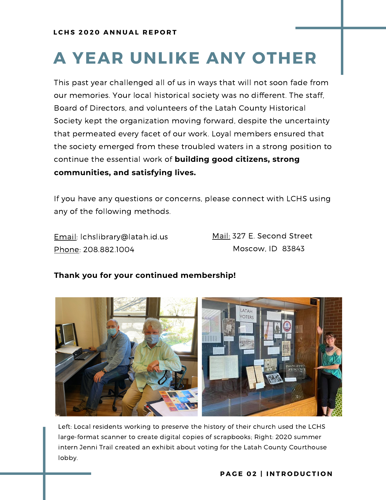

--- Doc 1 ---


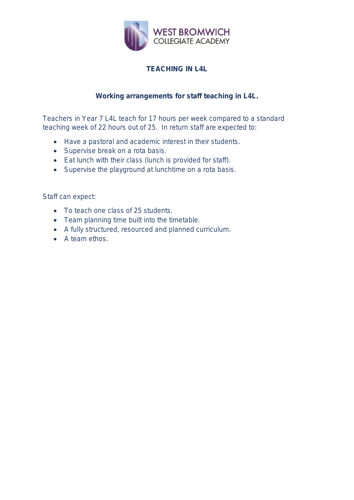

--- Doc 2 ---


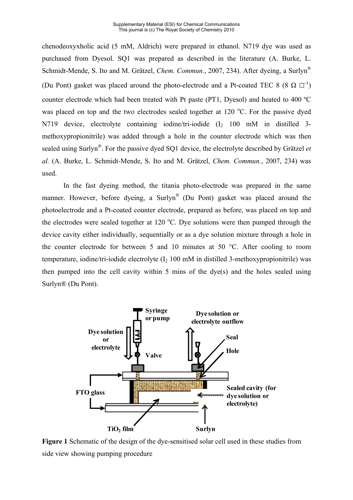

In [16]:
# Preview 3 random document images
from datasets import load_dataset
from itertools import islice
from IPython.display import display

ds = load_dataset("HuggingFaceM4/FineVision", "olmOCR-mix-0225-documents", split="train", streaming=True).shuffle(seed=123)
for i, s in enumerate(islice(ds, 3)):
    print(f"--- Doc {i} ---")
    img = s["images"][0]
    img.thumbnail((500, 500))  # Resize to max 400px
    display(img)

## Configuration

In [6]:
import os
import shutil
import tempfile
import time
from pathlib import Path

from huggingface_hub import HfApi, create_repo, fetch_job_logs, inspect_job, run_uv_job, whoami
from huggingface_hub._jobs_api import JobInfo, JobStage

In [50]:
# Set your HuggingFace token (required for private repos and pushing datasets)
# Get your token at: https://huggingface.co/settings/tokens
# ⚠️ Token needs jobs permission in the fine grained token settings 
import os
if not os.environ.get("HF_TOKEN"):
    os.environ["HF_TOKEN"] = input("Enter your HF token: ")

In [ ]:
# Authenticate with Hugging Face CLI
!hf auth login --token $HF_TOKEN

In [36]:
# Configuration
USERNAME = whoami()["name"]
HUB_IMAGE = "vllm/vllm-openai:v0.12.0"
HARDWARE_GPU = "a100-large"
HARDWARE_CPU = "cpu-upgrade"
TIMEOUT = "3h"

# Code and data repos
CODE_REPO = f"{USERNAME}/ocr-job-code"
DATASET_REPO = f"{USERNAME}/finevision-olmocr-processed"

# Source dataset
SOURCE_DATASET = "HuggingFaceM4/FineVision"
SOURCE_CONFIG = "olmOCR-mix-0225-documents"
MAX_SAMPLES =  128 #total number of samples to process

print(f"Code: {CODE_REPO} | Dataset: {DATASET_REPO}")
print(f"Source: {SOURCE_DATASET}/{SOURCE_CONFIG} ({MAX_SAMPLES} samples)")

Code: florentgbelidji/ocr-job-code | Dataset: florentgbelidji/finevision-olmocr-processed
Source: HuggingFaceM4/FineVision/olmOCR-mix-0225-documents (128 samples)


### 📝 DeepSeek-OCR Prompts

DeepSeek-OCR supports different prompts for various OCR tasks. See the [official config.py](https://github.com/deepseek-ai/DeepSeek-OCR/blob/main/DeepSeek-OCR-master/DeepSeek-OCR-vllm/config.py) for examples:

| Use Case | Prompt |
|----------|--------|
| **Document → Markdown** | `<image>\n<\|grounding\|>Convert the document to markdown.` |
| **General OCR** | `<image>\n<\|grounding\|>OCR this image.` |
| **Free OCR (no layout)** | `<image>\nFree OCR.` |
| **Parse figures** | `<image>\nParse the figure.` |
| **Describe image** | `<image>\nDescribe this image in detail.` |
| **Locate text** | `<image>\nLocate <\|ref\|>text<\|/ref\|> in the image.` |

The `<|grounding|>` token enables bounding box detection for figures and layout elements.


In [51]:
# Base environment for all stages
BASE_ENV = {
    # vLLM
    "MODEL_ID": "deepseek-ai/DeepSeek-OCR",
    "SERVED_MODEL_NAME": "deepseek-ocr",
    "HOST": "0.0.0.0",
    "PORT": "8000",
    "MAX_MODEL_LEN": "8192",
    "GPU_MEMORY_UTILIZATION": "0.90",
    "TENSOR_PARALLEL_SIZE": "1", #number of GPUs to use
    # Code
    "JOB_CODE_REPO": CODE_REPO,
    "JOB_CODE_REVISION": "main",
    "JOB_CODE_LOCAL_DIR": "/tmp/deepseek-ocr-job-code",
    # Auth
    "HF_TOKEN": os.environ.get("HF_TOKEN"),
    # Prompts
    "DOC_PROMPT": "<image>\n<|grounding|>Convert this document to Markdown.",
    "DOC_MAX_TOKENS": "4096",
    "DOC_TEMPERATURE": "0.1",
    "FIGURE_PROMPT": "<image>\nDescribe this image in detail.",
    "FIGURE_MAX_TOKENS": "512",
    "FIGURE_TEMPERATURE": "0.6",
}

## Upload Pipeline Code

In [38]:
# Upload code to HF Hub
CODE_PATHS = [
    Path("hf_job_runner.py"),
    Path("../llm_ocr"),
]

api = HfApi()
create_repo(repo_id=CODE_REPO, repo_type="dataset", exist_ok=True)
create_repo(repo_id=DATASET_REPO, repo_type="dataset", exist_ok=True)

bundle_dir = Path(tempfile.mkdtemp(prefix="job-code-"))
for path in CODE_PATHS:
    src = Path.cwd() / path if not path.is_absolute() else path
    if src.is_dir():
        shutil.copytree(src, bundle_dir / path.name, dirs_exist_ok=True)
    else:
        shutil.copy2(src, bundle_dir / path.name)

api.upload_folder(folder_path=str(bundle_dir), repo_id=CODE_REPO, repo_type="dataset")
print(f"Uploaded code to {CODE_REPO}")
print(f"Code repo: https://huggingface.co/datasets/{CODE_REPO}")

No files have been modified since last commit. Skipping to prevent empty commit.


Uploaded code to florentgbelidji/ocr-job-code
Code repo: https://huggingface.co/datasets/florentgbelidji/ocr-job-code


## Helper Functions

In [39]:
# Helper functions
CODE_URL = f"https://huggingface.co/datasets/{CODE_REPO}/resolve/main/hf_job_runner.py"

#launch job function
def launch(stage: str, flavor: str, env: dict) -> JobInfo:
    full_env = {**BASE_ENV, **env, "PIPELINE_STAGE": stage}
    job = run_uv_job(CODE_URL, image=HUB_IMAGE, flavor=flavor, env=full_env, timeout=TIMEOUT)
    print(f"Launched {stage}: {job.url}")
    return job

#wait for job to complete
def wait(job: JobInfo, poll: int = 60) -> JobInfo:
    while True:
        info = inspect_job(job_id=job.id)
        stage = info.status.stage
        print(f"  {job.id}: {stage}")
        if stage not in {JobStage.RUNNING, "RUNNING", "UPDATING"}:
            return info
        time.sleep(poll)

#print job logs
def logs(job: JobInfo, tail: int = 100):
    for line in list(fetch_job_logs(job_id=job.id, namespace=job.owner.name))[-tail:]:
        print(line, end="")


# Import rendering utilities from llm_ocr
import sys; sys.path.insert(0, "..")
from llm_ocr.document import render_sample_markdown, display_markdown

#display samples from dataset
def display_samples(dataset, num_samples: int = 2):
    """Display a few samples from the dataset."""
    from IPython.display import display, Markdown
    
    print(f"Dataset: {len(dataset)} samples")
    print(f"Columns: {list(dataset.column_names)}")
    print()
    
    for i in range(min(num_samples, len(dataset))):
        sample = dataset[i]
        print(f"=== Sample {i}: {sample['sample_id']} ===")
        
        # Show source image if available
        if sample.get('source_image'):
            print("Source image:")
            img = sample['source_image']
            img.thumbnail((500, 500))  # Resize to max 500px
            display(img)
        
        # Show markdown preview
        md = sample.get('document_markdown') or sample.get('document_markdown_text', '')
        if md:
            print(f"\nMarkdown preview ({len(md)} chars):")
            print(md[:500] + '...' if len(md) > 500 else md)
        
        # Show final markdown if available
        final_md = sample.get('document_final_markdown') or sample.get('document_final_markdown_text', '')
        if final_md:
            print(f"\nFinal markdown preview ({len(final_md)} chars):")
            print(final_md[:500] + '...' if len(final_md) > 500 else final_md)
        
        # Show figures and their descriptions
        figures = sample.get('extracted_figures', [])
        metadata = sample.get('extracted_figures_metadata', [])
        if figures:
            print(f"\nExtracted figures: {len(figures)}")
            for j, fig in enumerate(figures[:2]):  # Show max 2 figures
                fig.thumbnail((500, 500))
                display(fig)
                # Show figure description if available
                if j < len(metadata):
                    import json as _json
                    try:
                        meta = _json.loads(metadata[j]) if isinstance(metadata[j], str) else metadata[j]
                        if meta.get('description'):
                            print(f" Description: {meta['description'][:200]}...")
                    except:
                        pass
        print()

## Stage 1: Extract

Run DeepSeek OCR on each document image to produce Markdown and extract figure crops. This stage runs on GPU.

![Extract Stage Pipeline](../assets/extract-hf.png)

In [52]:
# Stage 1: Extract
stage1 = launch("extract", flavor=HARDWARE_GPU, env={
    "DATASET_NAME": SOURCE_DATASET,
    "DATASET_CONFIG": SOURCE_CONFIG,
    "DATASET_SPLIT": "train",
    "MAX_SAMPLES": str(MAX_SAMPLES),
    "OUTPUT_DIR": "./outputs",
    "EXTRACT_BATCH_SIZE": "128", #concurrent requests that form a batch
    "HF_REPO_ID": DATASET_REPO,
})


Launched extract: https://huggingface.co/jobs/florentgbelidji/696533585879a7164c033e88


In [53]:
stage1_done = wait(stage1)
print(f"Extract complete: {DATASET_REPO}")
print(f"Dataset: https://huggingface.co/datasets/{DATASET_REPO}")


  696533585879a7164c033e88: RUNNING
  696533585879a7164c033e88: RUNNING
  696533585879a7164c033e88: RUNNING
  696533585879a7164c033e88: COMPLETED
Extract complete: florentgbelidji/finevision-olmocr-processed
Dataset: https://huggingface.co/datasets/florentgbelidji/finevision-olmocr-processed


README.md:   0%|          | 0.00/614 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/130M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset: 128 samples
Columns: ['sample_id', 'dataset_index', 'source_image', 'document_with_boxes_image', 'document_markdown', 'extracted_figures', 'extracted_figures_metadata', 'document_final_markdown']

=== Sample 0: sample_00000 ===
Source image:


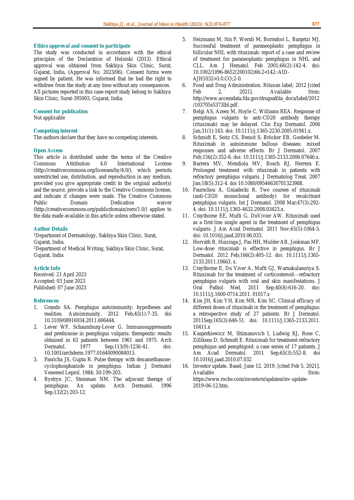


Markdown preview (4800 chars):
## Ethics approval and consent to participate  

Ethics approval and consent to participateThe study was conducted in accordance with the ethical principles of the Declaration of Helsinki (2013). Ethical approval was obtained from Sakhiya Skin Clinic, Surat, Gujarat, India. (Approval No: 2023/06). Consent forms were signed by patient. He was informed that he had the right to withdraw from the study at any time without any consequences. All pictures reported in this case- report study belong to S...

=== Sample 1: sample_00001 ===
Source image:


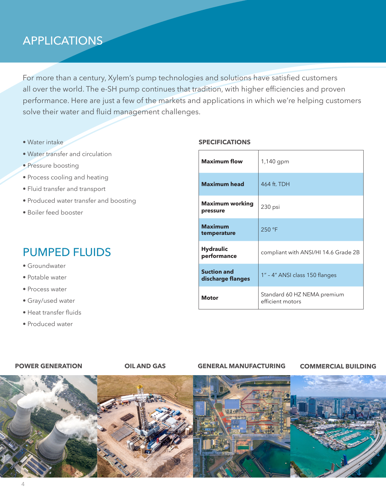


Markdown preview (1216 chars):
# APPLICATIONS  

For more than a century, Xylem's pump technologies and solutions have satisfied customers all over the world. The e- SH pump continues that tradition, with higher efficiencies and proven performance. Here are just a few of the markets and applications in which we're helping customers solve their water and fluid management challenges.  

Water intake- Water transfer and circulation- Pressure boosting- Process cooling and heating- Fluid transfer and transport- Produced water tran...

Extracted figures: 1


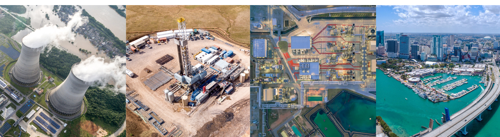

In [54]:
# Load and display samples after Extract
from datasets import load_dataset

ds_extract = load_dataset(DATASET_REPO, split="train")
display_samples(ds_extract, num_samples=2)

## Stage 2: Describe

Generate captions for each extracted figure using vision-language inference.

![Describe Stage Pipeline](../assets/describe-hf.png)

In [ ]:
# Stage 2: Describe
# Updates dataset in place (same repo)
stage2 = launch("describe", flavor=HARDWARE_GPU, env={
    "OUTPUT_DIR": "./outputs",
    "DESCRIBE_BATCH_SIZE": "32",
    "SOURCE_REPO_ID": DATASET_REPO,
    "HF_REPO_ID": DATASET_REPO,
})


Launched describe: https://huggingface.co/jobs/florentgbelidji/6965359d5879a7164c033e8f


In [56]:
stage2_done = wait(stage2)
print(f"Describe complete: {DATASET_REPO}")
print(f"Dataset: https://huggingface.co/datasets/{DATASET_REPO}")


  6965359d5879a7164c033e8f: RUNNING
  6965359d5879a7164c033e8f: RUNNING
  6965359d5879a7164c033e8f: RUNNING
  6965359d5879a7164c033e8f: RUNNING
  6965359d5879a7164c033e8f: RUNNING
  6965359d5879a7164c033e8f: COMPLETED
Describe complete: florentgbelidji/finevision-olmocr-processed
Dataset: https://huggingface.co/datasets/florentgbelidji/finevision-olmocr-processed


README.md:   0%|          | 0.00/614 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/130M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset: 128 samples
Columns: ['sample_id', 'dataset_index', 'source_image', 'document_with_boxes_image', 'document_markdown', 'extracted_figures', 'extracted_figures_metadata', 'document_final_markdown']

=== Sample 0: sample_00000 ===
Source image:


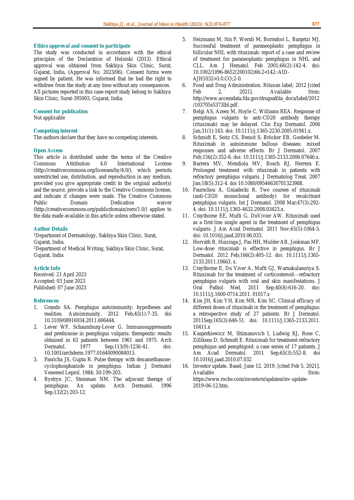


Markdown preview (4800 chars):
## Ethics approval and consent to participate  

Ethics approval and consent to participateThe study was conducted in accordance with the ethical principles of the Declaration of Helsinki (2013). Ethical approval was obtained from Sakhiya Skin Clinic, Surat, Gujarat, India. (Approval No: 2023/06). Consent forms were signed by patient. He was informed that he had the right to withdraw from the study at any time without any consequences. All pictures reported in this case- report study belong to S...

Final markdown preview (4800 chars):
## Ethics approval and consent to participate  

Ethics approval and consent to participateThe study was conducted in accordance with the ethical principles of the Declaration of Helsinki (2013). Ethical approval was obtained from Sakhiya Skin Clinic, Surat, Gujarat, India. (Approval No: 2023/06). Consent forms were signed by patient. He was informed that he had the right to withdraw from the study at any time without any 

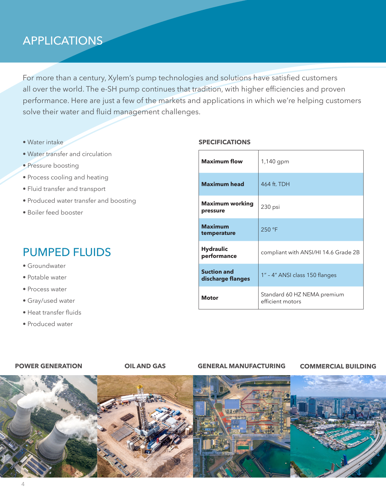


Markdown preview (1216 chars):
# APPLICATIONS  

For more than a century, Xylem's pump technologies and solutions have satisfied customers all over the world. The e- SH pump continues that tradition, with higher efficiencies and proven performance. Here are just a few of the markets and applications in which we're helping customers solve their water and fluid management challenges.  

Water intake- Water transfer and circulation- Pressure boosting- Process cooling and heating- Fluid transfer and transport- Produced water tran...

Final markdown preview (4366 chars):
# APPLICATIONS  

For more than a century, Xylem's pump technologies and solutions have satisfied customers all over the world. The e- SH pump continues that tradition, with higher efficiencies and proven performance. Here are just a few of the markets and applications in which we're helping customers solve their water and fluid management challenges.  

Water intake- Water transfer and circulation- Pressure boosting- Proc

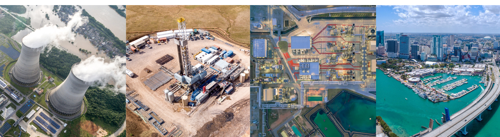

 Description: The figure provided showcases four different types of industrial facilities, each represented in a distinct section of the image. These facilities are part of the International Subscriber Nearshore (I...



In [59]:

from datasets import load_dataset
# Load and display samples after Describe
ds_describe = load_dataset(DATASET_REPO, split="train")
display_samples(ds_describe, num_samples=2)

## Stage 3: Assemble

Combine the original Markdown with figure captions to produce the final enriched document. The final document is added to the HF dataset. This stage can run on a CPU only.


![Assemble Stage Pipeline](../assets/assemble-hf.png)

In [60]:
# Stage 3: Assemble
# Updates dataset in place + saves final markdown files
stage3 = launch("assemble", flavor=HARDWARE_CPU, env={
    "OUTPUT_DIR": "./outputs",
    "SOURCE_REPO_ID": DATASET_REPO,
    "HF_REPO_ID": DATASET_REPO,
    "HF_COMMIT_MESSAGE": "Add assembled documents with figure captions",
})


Launched assemble: https://huggingface.co/jobs/florentgbelidji/6965374515f6de8b7dfb2532


In [61]:
stage3_done = wait(stage3)
print(f"Pipeline complete! Dataset: https://huggingface.co/datasets/{DATASET_REPO}")


  6965374515f6de8b7dfb2532: RUNNING
  6965374515f6de8b7dfb2532: COMPLETED
Pipeline complete! Dataset: https://huggingface.co/datasets/florentgbelidji/finevision-olmocr-processed


README.md:   0%|          | 0.00/615 [00:00<?, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/489M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/502M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1023 [00:00<?, ? examples/s]

Dataset: 1023 samples
Columns: ['sample_id', 'dataset_index', 'source_image', 'document_with_boxes_image', 'document_markdown', 'extracted_figures', 'extracted_figures_metadata', 'document_final_markdown']

=== Sample 0: sample_00000 ===
Source image:


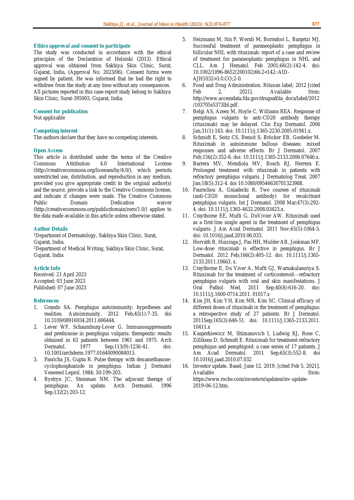


Markdown preview (4807 chars):
## Ethics approval and consent to participate  

Ethics approval and consent to participateThe study was conducted in accordance with the ethical principles of the Declaration of Helsinki (2013). Ethical approval was obtained from Sakhiya Skin Clinic, Surat, Gujarat, India. (Approval No: 2023/06). Consent forms were signed by patient. He was informed that he had the right to withdraw from the study at any time without any consequences. All pictures reported in this case- report study belong to S...

Final markdown preview (4807 chars):
## Ethics approval and consent to participate  

Ethics approval and consent to participateThe study was conducted in accordance with the ethical principles of the Declaration of Helsinki (2013). Ethical approval was obtained from Sakhiya Skin Clinic, Surat, Gujarat, India. (Approval No: 2023/06). Consent forms were signed by patient. He was informed that he had the right to withdraw from the study at any time without any 

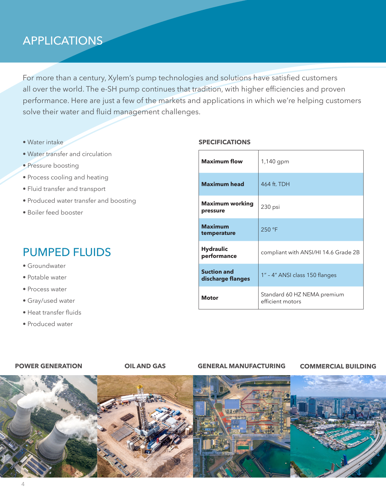


Markdown preview (1214 chars):
# APPLICATIONS  

For more than a century, Xylem's pump technologies and solutions have satisfied customers all over the world. The e- SH pump continues that tradition, with higher efficiencies and proven performance. Here are just a few of the markets and applications in which we're helping customers solve their water and fluid management challenges.  

Water intake- Water transfer and circulation- Pressure boosting- Process cooling and heating- Fluid transfer and transport- Produced water tran...

Final markdown preview (3525 chars):
# APPLICATIONS  

For more than a century, Xylem's pump technologies and solutions have satisfied customers all over the world. The e- SH pump continues that tradition, with higher efficiencies and proven performance. Here are just a few of the markets and applications in which we're helping customers solve their water and fluid management challenges.  

Water intake- Water transfer and circulation- Pressure boosting- Proc

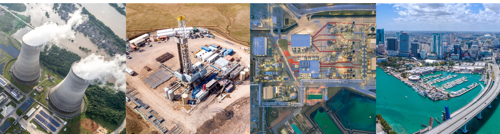

 Description: The figure provided showcases four different types of industrial facilities, each representing a distinct category of industrial structures. These categories are:

1. **Gas Turbine Power Plants (Leftm...



In [32]:
# Load and display final samples after Assemble
ds_final = load_dataset(DATASET_REPO, split="train")
display_samples(ds_final, num_samples=2)

## 💰 Cost Analysis (Extract stage only)

| Metric | Value |
|--------|-------|
| 🖥️ **Hardware** | Nvidia A100 (80GB) |
| ⚡ **Throughput** | ~85 documents/min |
| 🔄 **Concurrency** | -128 parallel requests (saturates GPU batch) |
| 💵 **Hourly rate** | [$2.50/hour](https://huggingface.co/pricing) |

| Scale | ⏱️ Time | 💲 Cost |
|-------|------|------|
| 1,000 docs | ~12 min | ~$0.50 |
| 10,000 docs | ~2 hours | ~$5 |
| 100,000 docs | ~20 hours | ~$50 |